In [1]:
### Loading Model & Modules ###
%matplotlib inline

import gzip
import os
import sys
import time
import pdb

from pylab import *

import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt

import theano
import theano.tensor as T
from theano.tensor.signal import downsample
from theano.tensor.nnet import conv
from theano.tensor.nnet import conv3d2d

import cPickle
import scipy
import random
import numpy
import h5py

matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

def nans(shape, dtype=float):
    a = numpy.empty(shape, dtype)
    a.fill(numpy.nan)
    return a

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
## Load Model

# Define different experiments
exp_vec = ['2012-08-09-3','2012-09-27-3','2013-08-19-6','2013-10-10-0']
cell_type_vec=['OFF','ON']

i_exp = 2 # which experiment do you want to look at, index of exp above
i_type = 0

params=[]
fname = '../TrainingModels/RNN50_2layers/RNN50_2layers_'+exp_vec[i_exp]+'_'+cell_type_vec[i_type]+'_parallelneurons_old_undone.save'
#fname = '../TrainingModels/Theano_GLMs/GLM_wnTimeFilt_'+exp_vec[i_exp]+'_'+cell_type_vec[i_type]+'_N65_undone.save'

f = open(fname, 'rb')
loadedModel = cPickle.load(f)
f.close()


In [3]:
# Ncells = 1 #loadedModel[2].shape[0]
# params = loadedModel[0]
# testscore = loadedModel[1]
# individualN_testscores = loadedModel[2]
# predictedTraces = loadedModel[3]
# actualTraces = loadedModel[4]
# trainEpochs = loadedModel[5]
# trainLosses = loadedModel[6]
# valEpochs = loadedModel[7]
# valLosses = loadedModel[8]
# testEpochs = loadedModel[9]
# testLosses = loadedModel[10]

# # Make sure traces are correct dimensions (some models switch them)
# if actualTraces.shape[0] != 3600:
#     actualTraces = numpy.transpose(actualTraces)
# if predictedTraces.shape[0] != 3600:
#     predictedTraces = numpy.transpose(predictedTraces)

# print 'Test Loss is '+ str(testscore/118/59)+''

In [4]:
## Define relevant variables - will be even more streamlined in the future (saving the models a new way)

Ncells = loadedModel[9].shape[0]
params = loadedModel[0:8]
testscore = loadedModel[8]
individualN_testscores = loadedModel[9]
predictedTraces = loadedModel[10]
actualTraces = loadedModel[11]
trainEpochs = loadedModel[12]
trainLosses = loadedModel[13]
valEpochs = loadedModel[14]
valLosses = loadedModel[15]
testEpochs = loadedModel[16]
testLosses = loadedModel[17]

# Make sure traces are correct dimensions (some models switch them)
if actualTraces.shape[0] != 3600:
    actualTraces = numpy.transpose(actualTraces)
if predictedTraces.shape[0] != 3600:
    predictedTraces = numpy.transpose(predictedTraces)

print 'Test Loss is '+ str(testscore/118/59)+''

Test Loss is 802.466819879


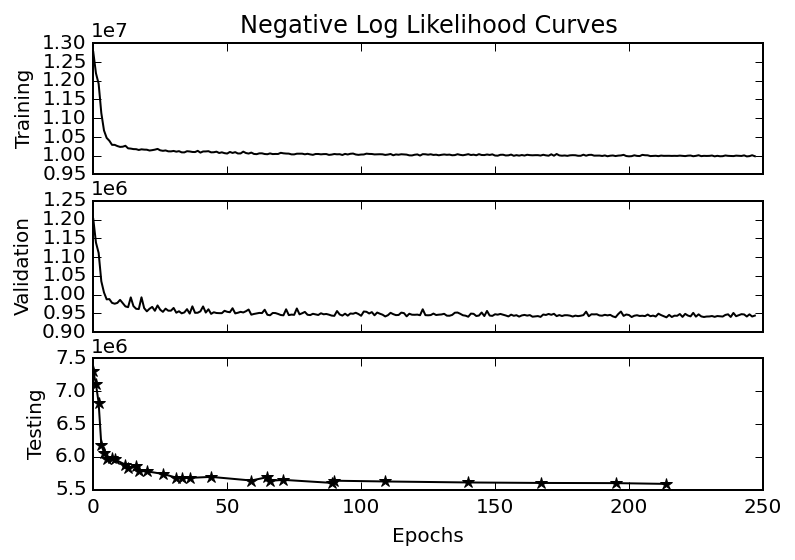

In [5]:
## Show training/validation/test curves

f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)

# Training curve
ax1.plot(trainEpochs, trainLosses,'k')
ax1.set_title('Negative Log Likelihood Curves')
ax1.set_ylabel('Training')

# Validation curve
ax2.plot(valEpochs, valLosses,'k')
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax2.set_ylabel('Validation')

# Testing curve
ax3.plot(testEpochs,testLosses,'-*k')
ax3.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax3.set_ylabel('Testing')
ax3.set_xlabel('Epochs')



In [6]:
## Generate Spikes/Calculate Correlation Coefficients
ntrials = 59
CorrCoefs = nans((int(Ncells)))
# Real responses
actualSpikes = numpy.load('../TrainingModels/TestResponses/NSEM_'+exp_vec[i_exp]+'_'+cell_type_vec[i_type]+'_testResponses.npy')

predSpikes=numpy.zeros((int(Ncells),ntrials,3600))

for i_n in xrange(int(Ncells)):
    
    # Model responses
    ypred = predictedTraces[:,i_n]
    for i in xrange(0,ntrials):
        predSpikes[i_n,i,:] = numpy.random.poisson(ypred)

    ## Correlation Coefficients  
    CC_temp = numpy.corrcoef(numpy.mean(actualSpikes[i_n,:,120:],axis=0),numpy.mean(predSpikes[i_n,:,120:],axis=0))
    CorrCoefs[i_n] = CC_temp[0,1]
    
print 'Mean correlation coefficient is '+ str(numpy.mean(CorrCoefs))+''

Mean correlation coefficient is 0.759498181485


In [15]:
numpy.array((19,33))

array([19, 33])

In [19]:
print CorrCoefs[numpy.array((19,33,65,113,114))]
#print normalizedLL[114]/59.

[ 0.82147308  0.7426513   0.84277031  0.66448192  0.70649069]


In [ ]:
## Relative Information

Eyx = predictedTraces[120:,:].astype('float64')
true_y = actualTraces[120:,:]

# LL of p(s|x)
LL = (true_y*numpy.log2(Eyx))+numpy.log2(numpy.exp(-Eyx*59.)) #-T.log2(scipy.misc.factorial(true_y))

# LL of p(s)
meanFR = numpy.array(sum(true_y[120:,:],axis=0)/3480./59,dtype='float64')
LL_meanFR = (true_y*numpy.log2(meanFR))+numpy.log2(numpy.exp(-meanFR*59.)) #-T.log2(scipy.misc.factorial(true_y))

# Put them together
normalizedLL = (numpy.sum(LL - LL_meanFR,axis=0)*120.)/3480. # in bits/second

print 'Mean normalizedLL is '+ str(numpy.mean(normalizedLL)/59.)+''

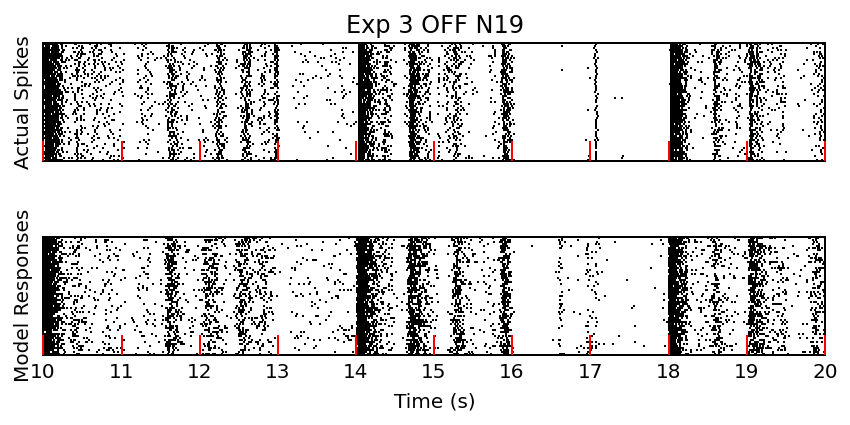

In [21]:
## Rasters
sys.path.insert(0, '../MiscellaneousCode/')
import plotRasters

for i_n in xrange(19,20):
    plt.clf() 
     
    # Real responses
    actSpikeBins=[]
    for i in xrange(0,59):
        actSpikeBins.append(numpy.nonzero(actualSpikes[i_n,i,:]))

    ax = plt.subplot(311)
    ax = plotRasters.raster(actSpikeBins)
    plt.title('Exp '+str(i_exp+1)+' '+cell_type_vec[i_type]+' N'+str(i_n)+'')
    plt.ylabel('Actual Spikes')
    plt.xlim([1200,2400])
    
    # Model Responses
    predSpikeBins=[]
    for i in xrange(0,59):
        predSpikeBins.append(numpy.nonzero(predSpikes[i_n,i,:]))        

    ax = plt.subplot(312)
    ax = plotRasters.raster2(predSpikeBins)
    plt.ylabel('Model Responses')
    plt.xlabel('Time (s)')
    plt.xlim([1200,2400])
  
    plt.tight_layout()
    
    #plt.savefig('Rasters2/Raster_'+str(i_exp+1)+'_'+cell_type[i_type]+'_N'+str(i_n)+'.png')